In [22]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure


In [37]:
from PIL import Image
im = Image.open("DB1_B/104_1.tif")
im.show()

In [28]:
fd, hog_image = hog(im, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel = False)

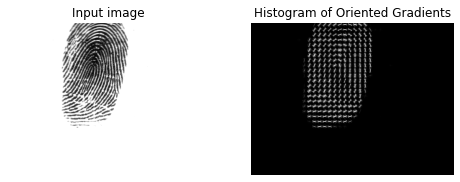

<Figure size 576x288 with 0 Axes>

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
plt.figure(figsize = (8,4))
ax1.axis('off')
ax1.imshow(im, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [11]:
!pip install opencv-python

     |████████████████████████████████| 40.3 MB 10.5 MB/s eta 0:00:01    |█████████▍                      | 11.7 MB 3.7 MB/s eta 0:00:08


In [8]:
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.show()

In [52]:
import cv2
cv2.imshow('Gray image', hog_image_rescaled)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
%history -g -f 

# Gray Scale

In [1]:
import cv2

In [2]:
image = cv2.imread('103_3-p1f1b1dt1j8111l9p1u7e13sg1o90.png')

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
cv2.imshow('Gray image', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Normalisation

In [4]:
from math import sqrt
import numpy as np


def normalize_pixel(x, v0, v, m, m0):
    """
    From Handbook of Fingerprint Recognition pg 133
    Normalize job used by Hong, Wan and Jain(1998)
    similar to https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf equation 21
    :param x: pixel value
    :param v0: desired variance
    :param v: global image variance
    :param m: global image mean
    :param m0: desired mean
    :return: normilized pixel
    """
    dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
    return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

In [17]:
result = normalize(gray, m0 = 200, v0 = 200)

In [18]:
cv2.imshow(' image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Segmentation

In [21]:
import numpy as np
import cv2 as cv


def normalise(img):
    return (img - np.mean(img))/(np.std(img))


def create_segmented_and_variance_images(im, w, threshold=.2):
    """
    Returns mask identifying the ROI. Calculates the standard deviation in each image block and threshold the ROI
    It also normalises the intesity values of
    the image so that the ridge regions have zero mean, unit standard
    deviation.
    :param im: Image
    :param w: size of the block
    :param threshold: std threshold
    :return: segmented_image
    """
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # normalize segmented image
    segmented_image *= mask
    im = normalise(im)
    mean_val = np.mean(im[mask==0])
    std_val = np.std(im[mask==0])
    norm_img = (im - mean_val)/(std_val)

    return segmented_image, norm_img, mask

In [41]:
segmented_image ,y,z = create_segmented_and_variance_images(gray, 16, )

In [40]:
cv2.imshow('x', x)
cv2.imshow('y', y)
cv2.imshow('z', z)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Orientation (Gradient)

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

In [45]:
fd, hog_image = hog(segmented_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel = False)

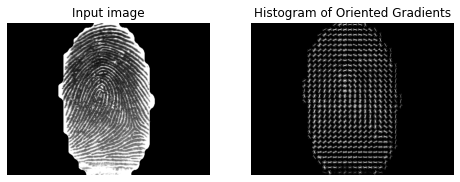

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(segmented_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

# Skeletonize

In [49]:
pip install python3-utils

Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
import cv2 as cv
from utils.crossing_number import calculate_minutiaes
from skimage.morphology import skeletonize as skelt
from skimage.morphology import thin
def skeletonize(image_input):
    """
    https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
    Skeletonization reduces binary objects to 1 pixel wide representations.
    skeletonize works by making successive passes of the image. On each pass, border pixels are identified
    and removed on the condition that they do not break the connectivity of the corresponding object.
    :param image_input: 2d array uint8
    :return:
    """
    image = np.zeros_like(image_input)
    image[image_input == 0] = 1.0
    output = np.zeros_like(image_input)

    skeleton = skelt(image)

    """uncomment for testing"""
    # thinned = thin(image)
    # thinned_partial = thin(image, max_iter=25)
    #
    # def minu_(skeleton, name):
    #     cv.imshow('thin_'+name, output)
    #     cv.bitwise_not(output, output)
    #     minutias = calculate_minutiaes(output, kernel_size=5); cv.imshow('minu_'+name, minutias)
    # # minu_(output, 'skeleton')
    # # minu_(output, 'thinned')
    # # minu_(output, 'thinned_partial')
    # # cv.waitKeyEx()

    output[skeleton] = 255
    cv.bitwise_not(output, output)

    return output


def thinning_morph(image, kernel):
    """
    Thinning image using morphological operations
    :param image: 2d array uint8
    :param kernel: 3x3 2d array unint8
    :return: thin images
    """
    thining_image = np.zeros_like(image)
    img = image.copy()

    while 1:
        erosion = cv.erode(img, kernel, iterations = 1)
        dilatate = cv.dilate(erosion, kernel, iterations = 1)

        subs_img = np.subtract(img, dilatate)
        cv.bitwise_or(thining_image, subs_img, thining_image)
        img = erosion.copy()

        done = (np.sum(img) == 0)

        if done:
          break

    # shift down and compare one pixel offset
    down = np.zeros_like(thining_image)
    down[1:-1, :] = thining_image[0:-2, ]
    down_mask = np.subtract(down, thining_image)
    down_mask[0:-2, :] = down_mask[1:-1, ]
    cv.imshow('down', down_mask)

    # shift right and compare one pixel offset
    left = np.zeros_like(thining_image)
    left[:, 1:-1] = thining_image[:, 0:-2]
    left_mask = np.subtract(left, thining_image)
    left_mask[:, 0:-2] = left_mask[:, 1:-1]
    cv.imshow('left', left_mask)

    # combine left and down mask
    cv.bitwise_or(down_mask, down_mask, thining_image)
    output = np.zeros_like(thining_image)
    output[thining_image < 250] = 255

    return output

ModuleNotFoundError: No module named 'utils'

<Figure size 3600x3600 with 0 Axes>

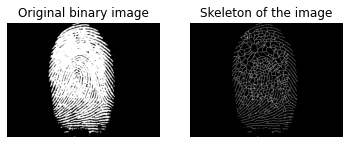

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
"load image data"
Img_Original =  io.imread( '103_3-p1f1b1dt1j8111l9p1u7e13sg1o90.png')      # Gray image, rgb images need pre-conversion

"Convert gray images to binary images using Otsu's method"
from skimage.filters import threshold_otsu
Otsu_Threshold = threshold_otsu(Img_Original)   
BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 !

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned
 

"Apply the algorithm on images"
BW_Skeleton = zhangSuen(BW_Original)
# BW_Skeleton = BW_Original
"Display the results"
plt.figure(figsize = (50, 50))
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.ravel()
ax1.imshow(BW_Original, cmap=plt.cm.gray)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('Skeleton of the image')
ax2.axis('off')
plt.show()